## Building MetaData

The building metadata file houses data about the buildings for which the meter data has been recorded and gives us information about the type of the building, area covered, energy sources used, etc 

In [1]:
# Importing the required libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'Arial'})

import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import geopandas as gpd
from shapely.geometry import Point, Polygon
import gc

In [2]:
# Specifying the filepath for the data 
path = "../../data/metadata/"

In [3]:
# Buildings MetaData data
metadata = pd.read_csv(path + "metadata.csv")

# Inspecting the some columns of the data 
metadata.sample(5)

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
448,Rat_education_Stuart,Rat,405.0,3.0,Education,K-12 School,7636.6,82200.0,38.903504,-77.005349,...,1916.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,Fox_office_Alice,Fox,246.0,2.0,Office,Office,18806.8,202435.0,33.424425,-111.928140,...,1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,Rat_public_Nell,Rat,301.0,3.0,Public services,Police Station,4754.4,51176.0,38.903504,-77.005349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473,Eagle_office_Phyllis,Eagle,1297.0,14.0,Office,Office,1994.5,21469.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,Rat_public_Chrissy,Rat,296.0,3.0,Public services,Library,2043.9,22000.0,38.903504,-77.005349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Inspecting the columns of the metadata
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            1636 non-null   object 
 1   site_id                1636 non-null   object 
 2   building_id_kaggle     1449 non-null   float64
 3   site_id_kaggle         1599 non-null   float64
 4   primaryspaceusage      1615 non-null   object 
 5   sub_primaryspaceusage  1615 non-null   object 
 6   sqm                    1636 non-null   float64
 7   sqft                   1636 non-null   float64
 8   lat                    1399 non-null   float64
 9   lng                    1399 non-null   float64
 10  timezone               1636 non-null   object 
 11  electricity            1578 non-null   object 
 12  hotwater               185 non-null    object 
 13  chilledwater           555 non-null    object 
 14  steam                  370 non-null    object 
 15  wate

## Exploratory Data Analysis (EDA)

### Shape of the Data 

In [5]:
metadata.shape

(1636, 32)

We have building metadata for 1636 buildings 

In [6]:
metadata.dtypes

building_id               object
site_id                   object
building_id_kaggle       float64
site_id_kaggle           float64
primaryspaceusage         object
sub_primaryspaceusage     object
sqm                      float64
sqft                     float64
lat                      float64
lng                      float64
timezone                  object
electricity               object
hotwater                  object
chilledwater              object
steam                     object
water                     object
irrigation                object
solar                     object
gas                       object
industry                  object
subindustry               object
heatingtype               object
yearbuilt                float64
date_opened               object
numberoffloors           float64
occupants                float64
energystarscore           object
eui                       object
site_eui                  object
source_eui                object
leed_level

In [7]:
# Deleting the Kaggle IDs since this data was reproduced for a Kaggle Competion 
metadata = metadata.drop(columns=['building_id_kaggle', 'site_id_kaggle'])

### Missing Values 

In [8]:
# Percentage of missing values in each feature
na_features = [features for features in metadata.columns if metadata[features].isnull().sum() > 0]
for features in na_features:
    # Updated to round the missing values percentage to two decimal places
    print(f"{features} : {round(metadata[features].isnull().mean() * 100, 2)}%")

primaryspaceusage : 1.28%
sub_primaryspaceusage : 1.28%
lat : 14.49%
lng : 14.49%
electricity : 3.55%
hotwater : 88.69%
chilledwater : 66.08%
steam : 77.38%
water : 91.08%
irrigation : 97.74%
solar : 99.69%
gas : 89.18%
industry : 64.61%
subindustry : 64.61%
heatingtype : 86.86%
yearbuilt : 50.06%
date_opened : 98.72%
numberoffloors : 73.04%
occupants : 85.94%
energystarscore : 90.04%
eui : 81.72%
site_eui : 90.04%
source_eui : 90.04%
leed_level : 99.02%
rating : 88.75%


### Feature Exploration 

In [9]:
# Function to divide the different feature data types 
def categorize_variables(df):
    
    categorical = []
    discrete = []
    continuous = []
    datetime = []
    
    for column in df.columns:
        
        if pd.api.types.is_datetime64_any_dtype(df[column]):
            datetime.append(column)
            
        if pd.api.types.is_numeric_dtype(df[column]):
            
            if len(df[column].unique()) / len(df) < 0.05:
                discrete.append(column)
                
            else:
                continuous.append(column)
                
        elif pd.api.types.is_object_dtype(df[column]):
            categorical.append(column)
            
        else:
            categorical.append(column)
    
    return categorical, discrete, continuous, datetime

In [10]:
# Applying the above function to segregate the features 
categorical,discrete,continuous,datetime = categorize_variables(metadata)
numeric = discrete + continuous

print("Categorical: ", categorical)
print("Discrete: ", discrete)
print("Continuous: ", continuous)
print("Numeric: ", numeric)

Categorical:  ['building_id', 'site_id', 'primaryspaceusage', 'sub_primaryspaceusage', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam', 'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry', 'heatingtype', 'date_opened', 'energystarscore', 'eui', 'site_eui', 'source_eui', 'leed_level', 'rating']
Discrete:  ['lat', 'lng', 'numberoffloors']
Continuous:  ['sqm', 'sqft', 'yearbuilt', 'occupants']
Numeric:  ['lat', 'lng', 'numberoffloors', 'sqm', 'sqft', 'yearbuilt', 'occupants']


#### Numeric Variables 

##### Univariate Analysis 

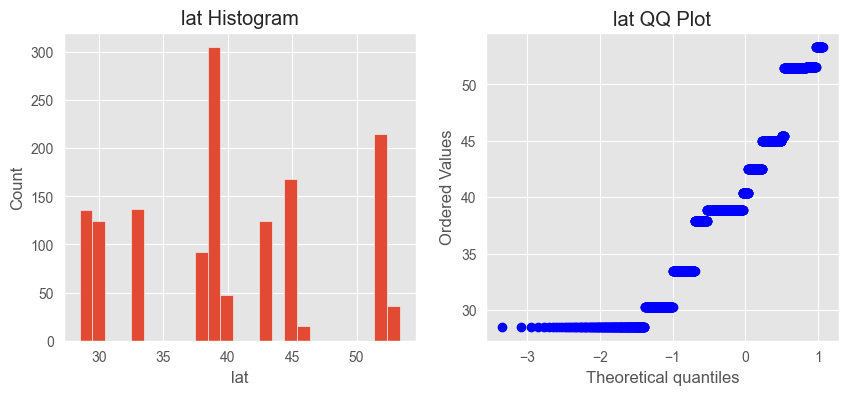

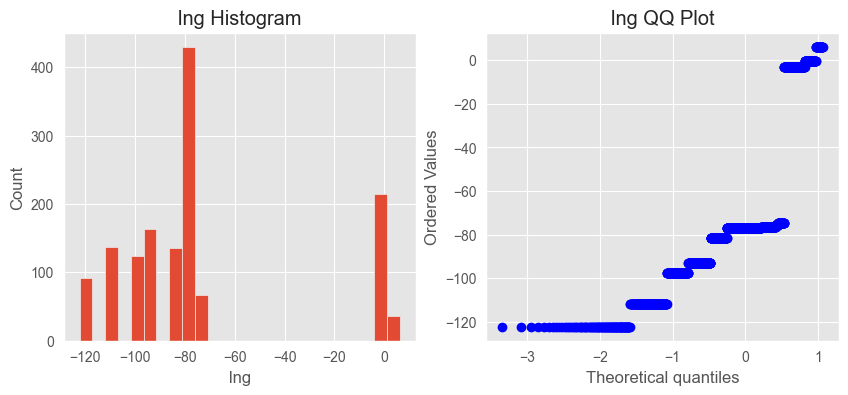

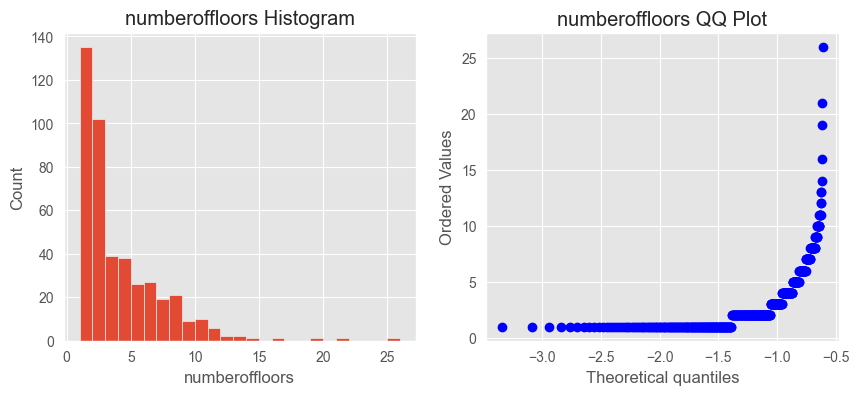

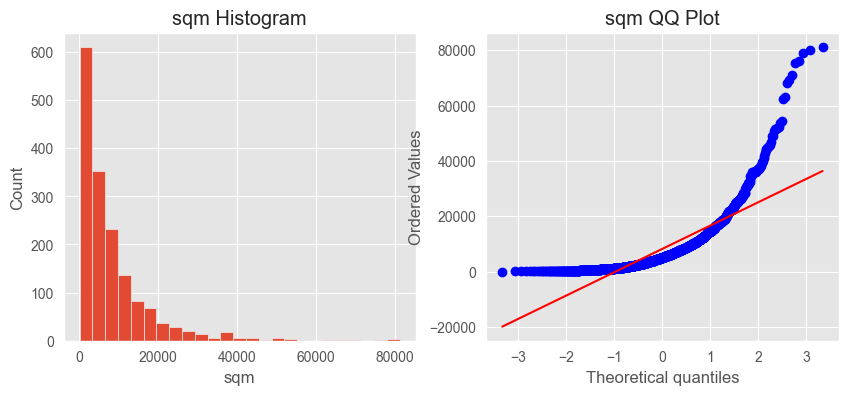

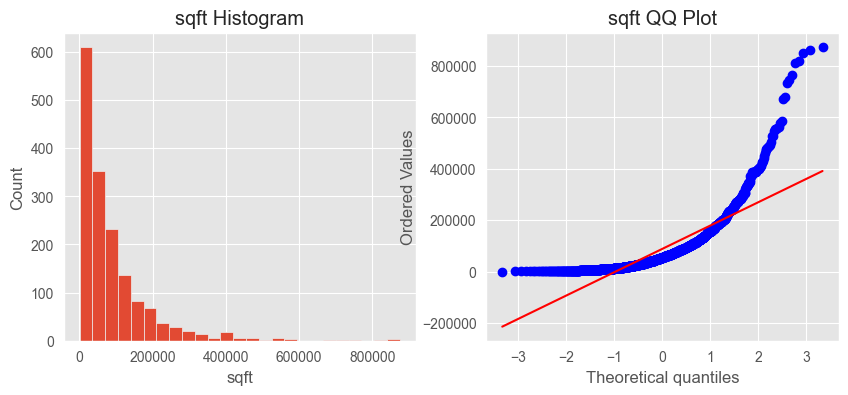

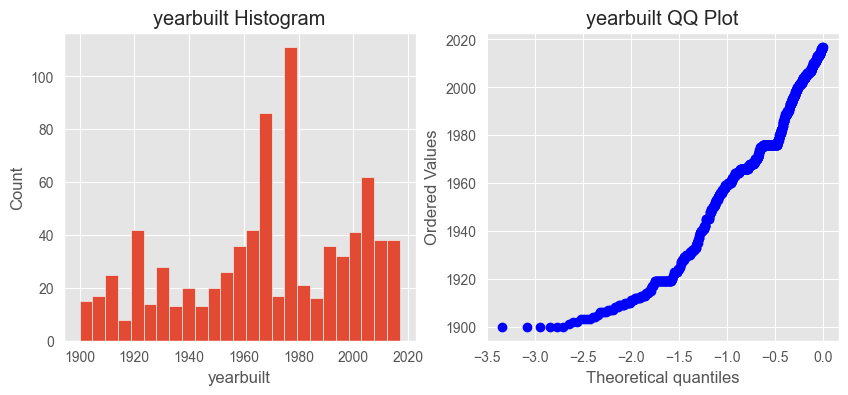

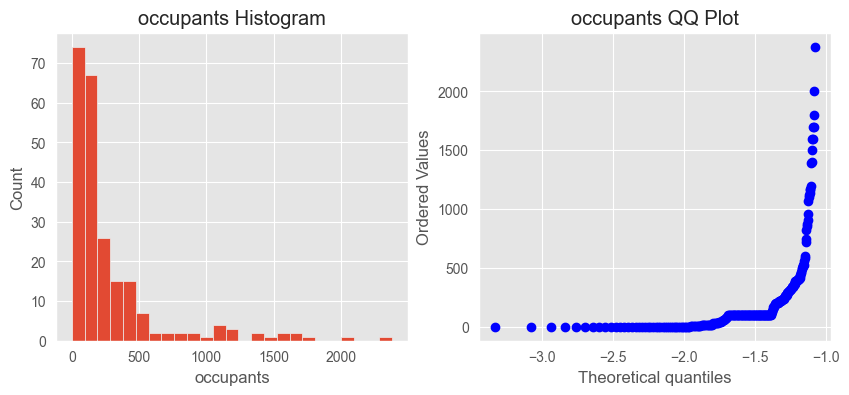

In [11]:
# Looping through all the numeric columns to get a histogram to see distribution and QQ plot to check normality 
for feature in numeric:
    data = metadata.copy()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)  
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature + ' Histogram')
    
    plt.subplot(1, 2, 2) 
    stats.probplot(data[feature], dist="norm", plot=plt)
    plt.title(feature + ' QQ Plot')

    plt.show()

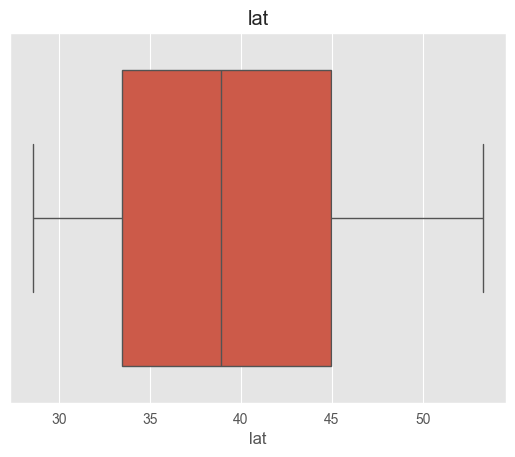

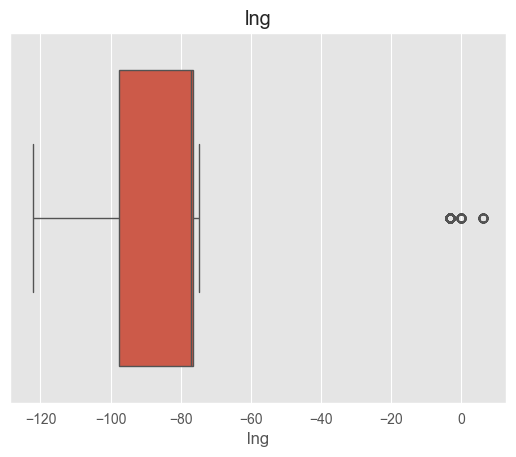

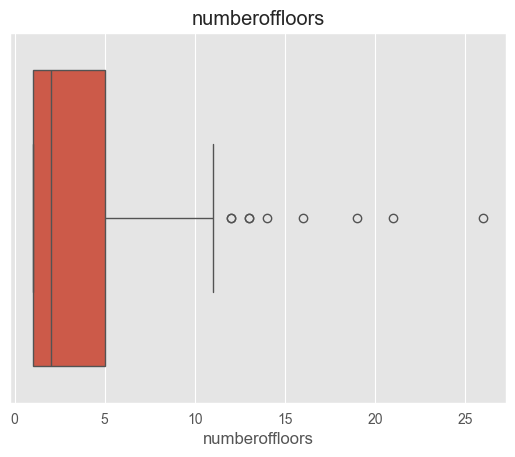

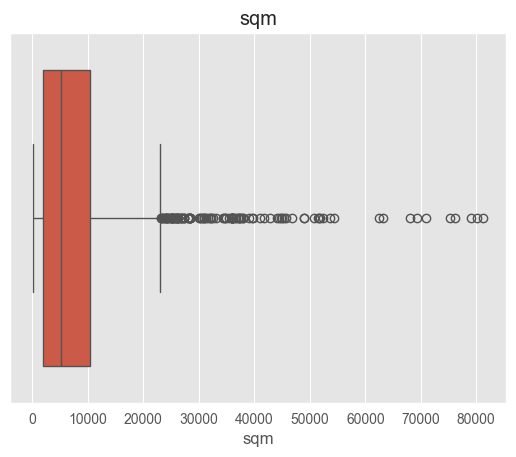

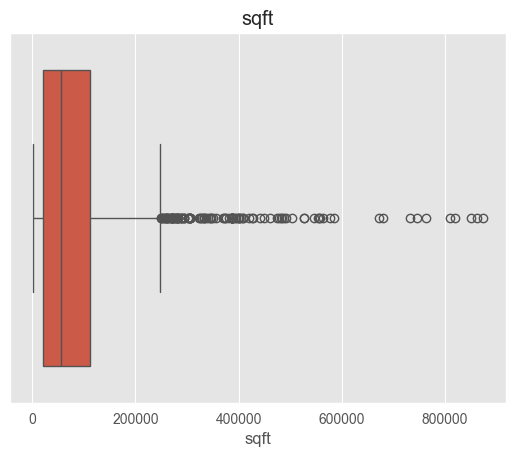

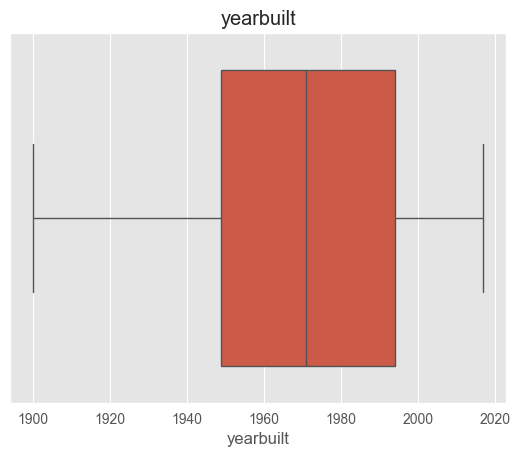

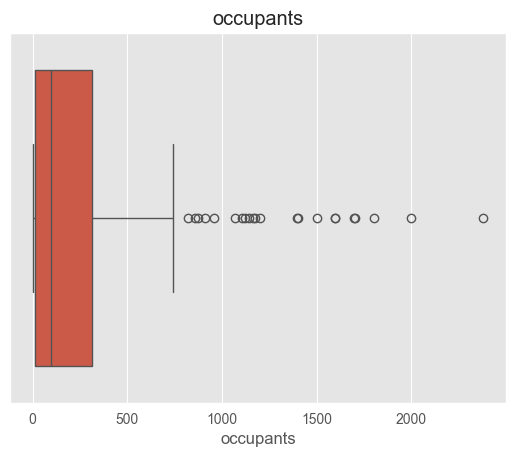

In [12]:
# Box Plots to asess for outliers 
for features in numeric:
    sns.boxplot(x = metadata[features])
    plt.title(features)
    plt.show()

##### Bivariate Analysis 

<Axes: >

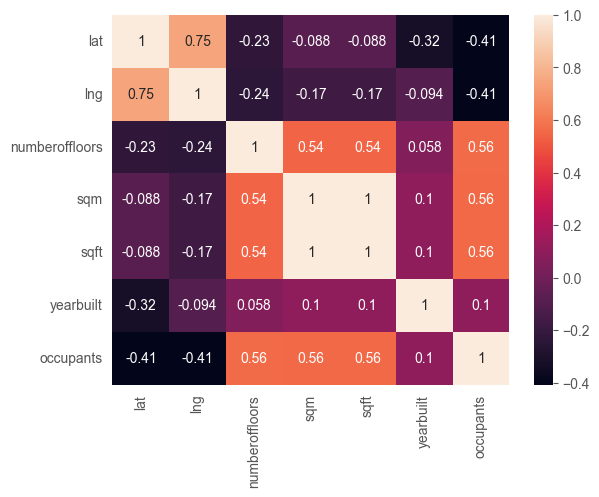

In [13]:
# Correlation plot to assess if there is any synergy between the numeric predictors 
sns.heatmap(metadata[numeric].corr(), annot = True)

#### Categorical Variables 

##### Univariate Analysis 

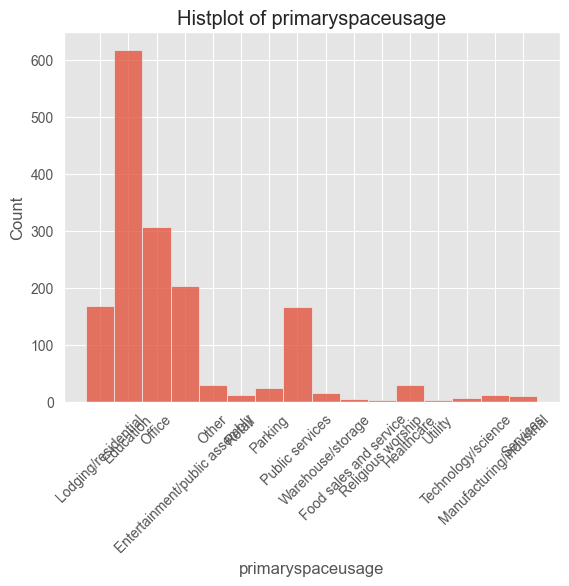

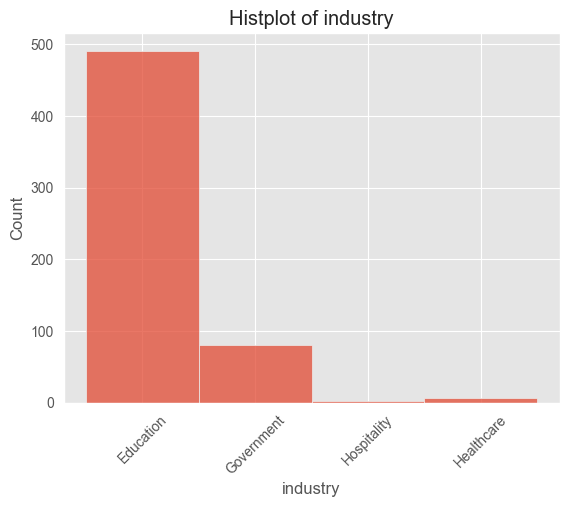

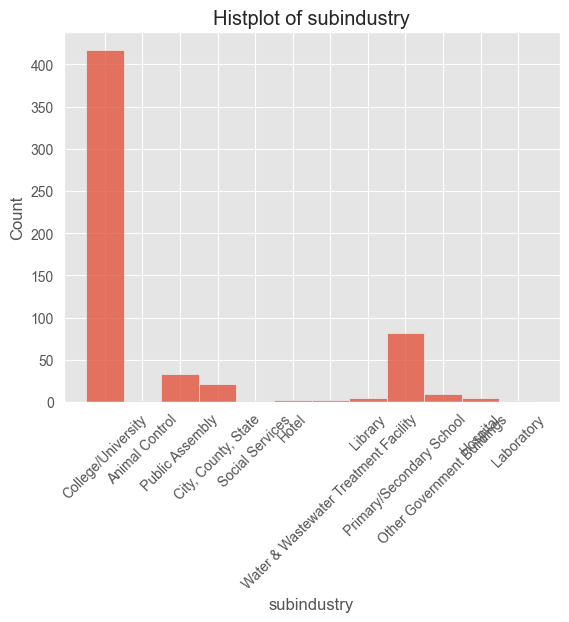

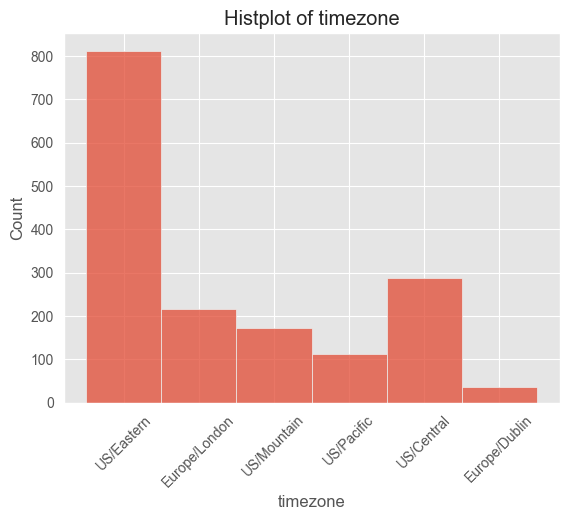

In [14]:
# While there are a lot of categprical features in this data frame, we will do EDA on a select few based on intuition and %missing values
categorical_selected = ["primaryspaceusage","industry","subindustry","timezone"]

for columns in categorical_selected:    
    sns.histplot(data=metadata, x=columns)
    plt.title(f'Histplot of {columns}')
    plt.xticks(rotation=45) 
    plt.show()

#### Sites Location Analysis

In [16]:
# World map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Exclude Antartica
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

# Coordinate reference system used in this map
world.crs

/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_71412/978216947.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Latitude and longitude are of the site location (all buildings from the same location shares lng and lat values).

In [20]:
# Processing the data so that we can visualise the sites on a map 
sites = metadata[["site_id","lat","lng"]].groupby("site_id").median()

# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (sites["lng"], sites["lat"])]

# Creates geoDataFrame
geo_sites = gpd.GeoDataFrame(sites, crs = world.crs, geometry = geometry)

(20.0, 60.0)

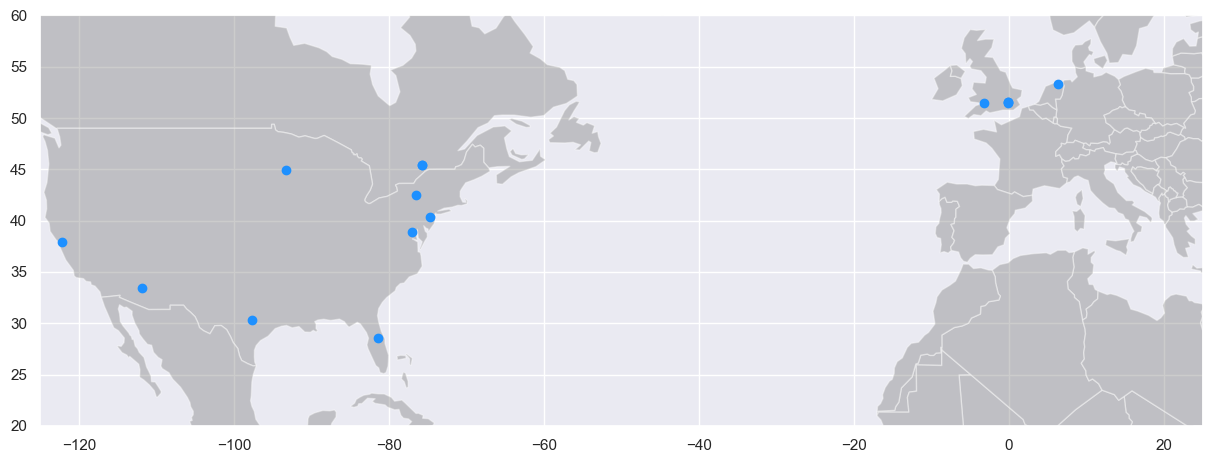

In [21]:
# Plotting the sites on a world map to understand the distribution of our data geographically 
fig, ax = plt.subplots(figsize = (15,15))
world.plot(ax = ax, alpha = 0.4, color = "grey")
geo_sites.plot(ax = ax, color = "dodgerblue")
ax.set_xlim([-125, 25])
ax.set_ylim([20, 60])

##### Bivariate Analysis 

<Axes: xlabel='site_id'>

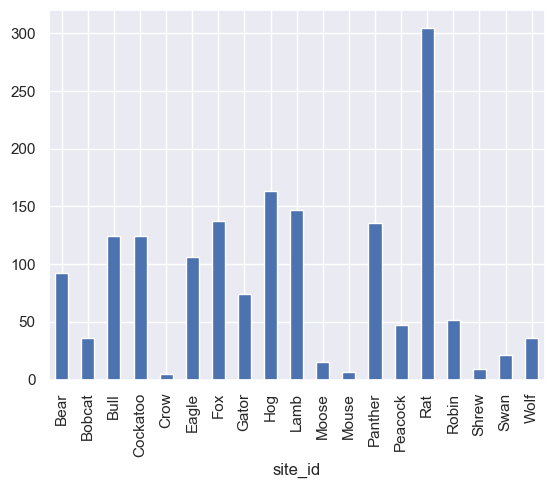

In [24]:
# Number of buildings in each site
metadata.groupby("site_id").building_id.count().plot(kind = "bar")

<Axes: xlabel='site_id'>

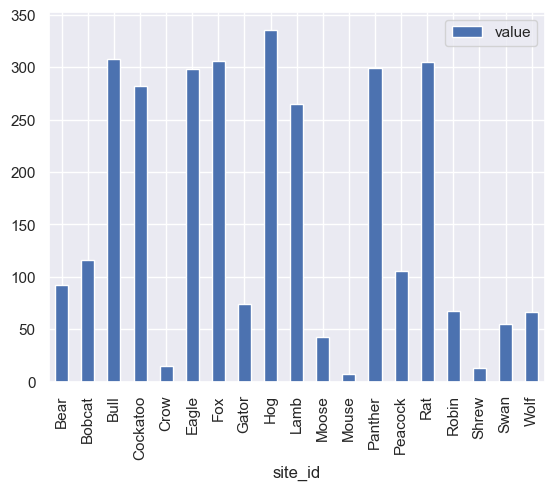

In [28]:
# Number of meters per site 
temp = pd.melt(metadata[["site_id","electricity","hotwater","chilledwater","steam","water","irrigation","gas","solar"]],id_vars = "site_id", var_name="meter")
bysite = temp[temp.value == "Yes"].groupby(["site_id","meter"]).count().groupby("site_id").sum().plot(kind = "bar")
bysite

In [26]:
print("Total number of meters: " + str(len(temp.dropna())))

Total number of meters: 3053


/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_71412/1571310570.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0] # number of meters
/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_71412/1571310570.py:117: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g7 = sns.distplot(metadata["sqm"], ax=ax7, color=color)
/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_71412/1571310

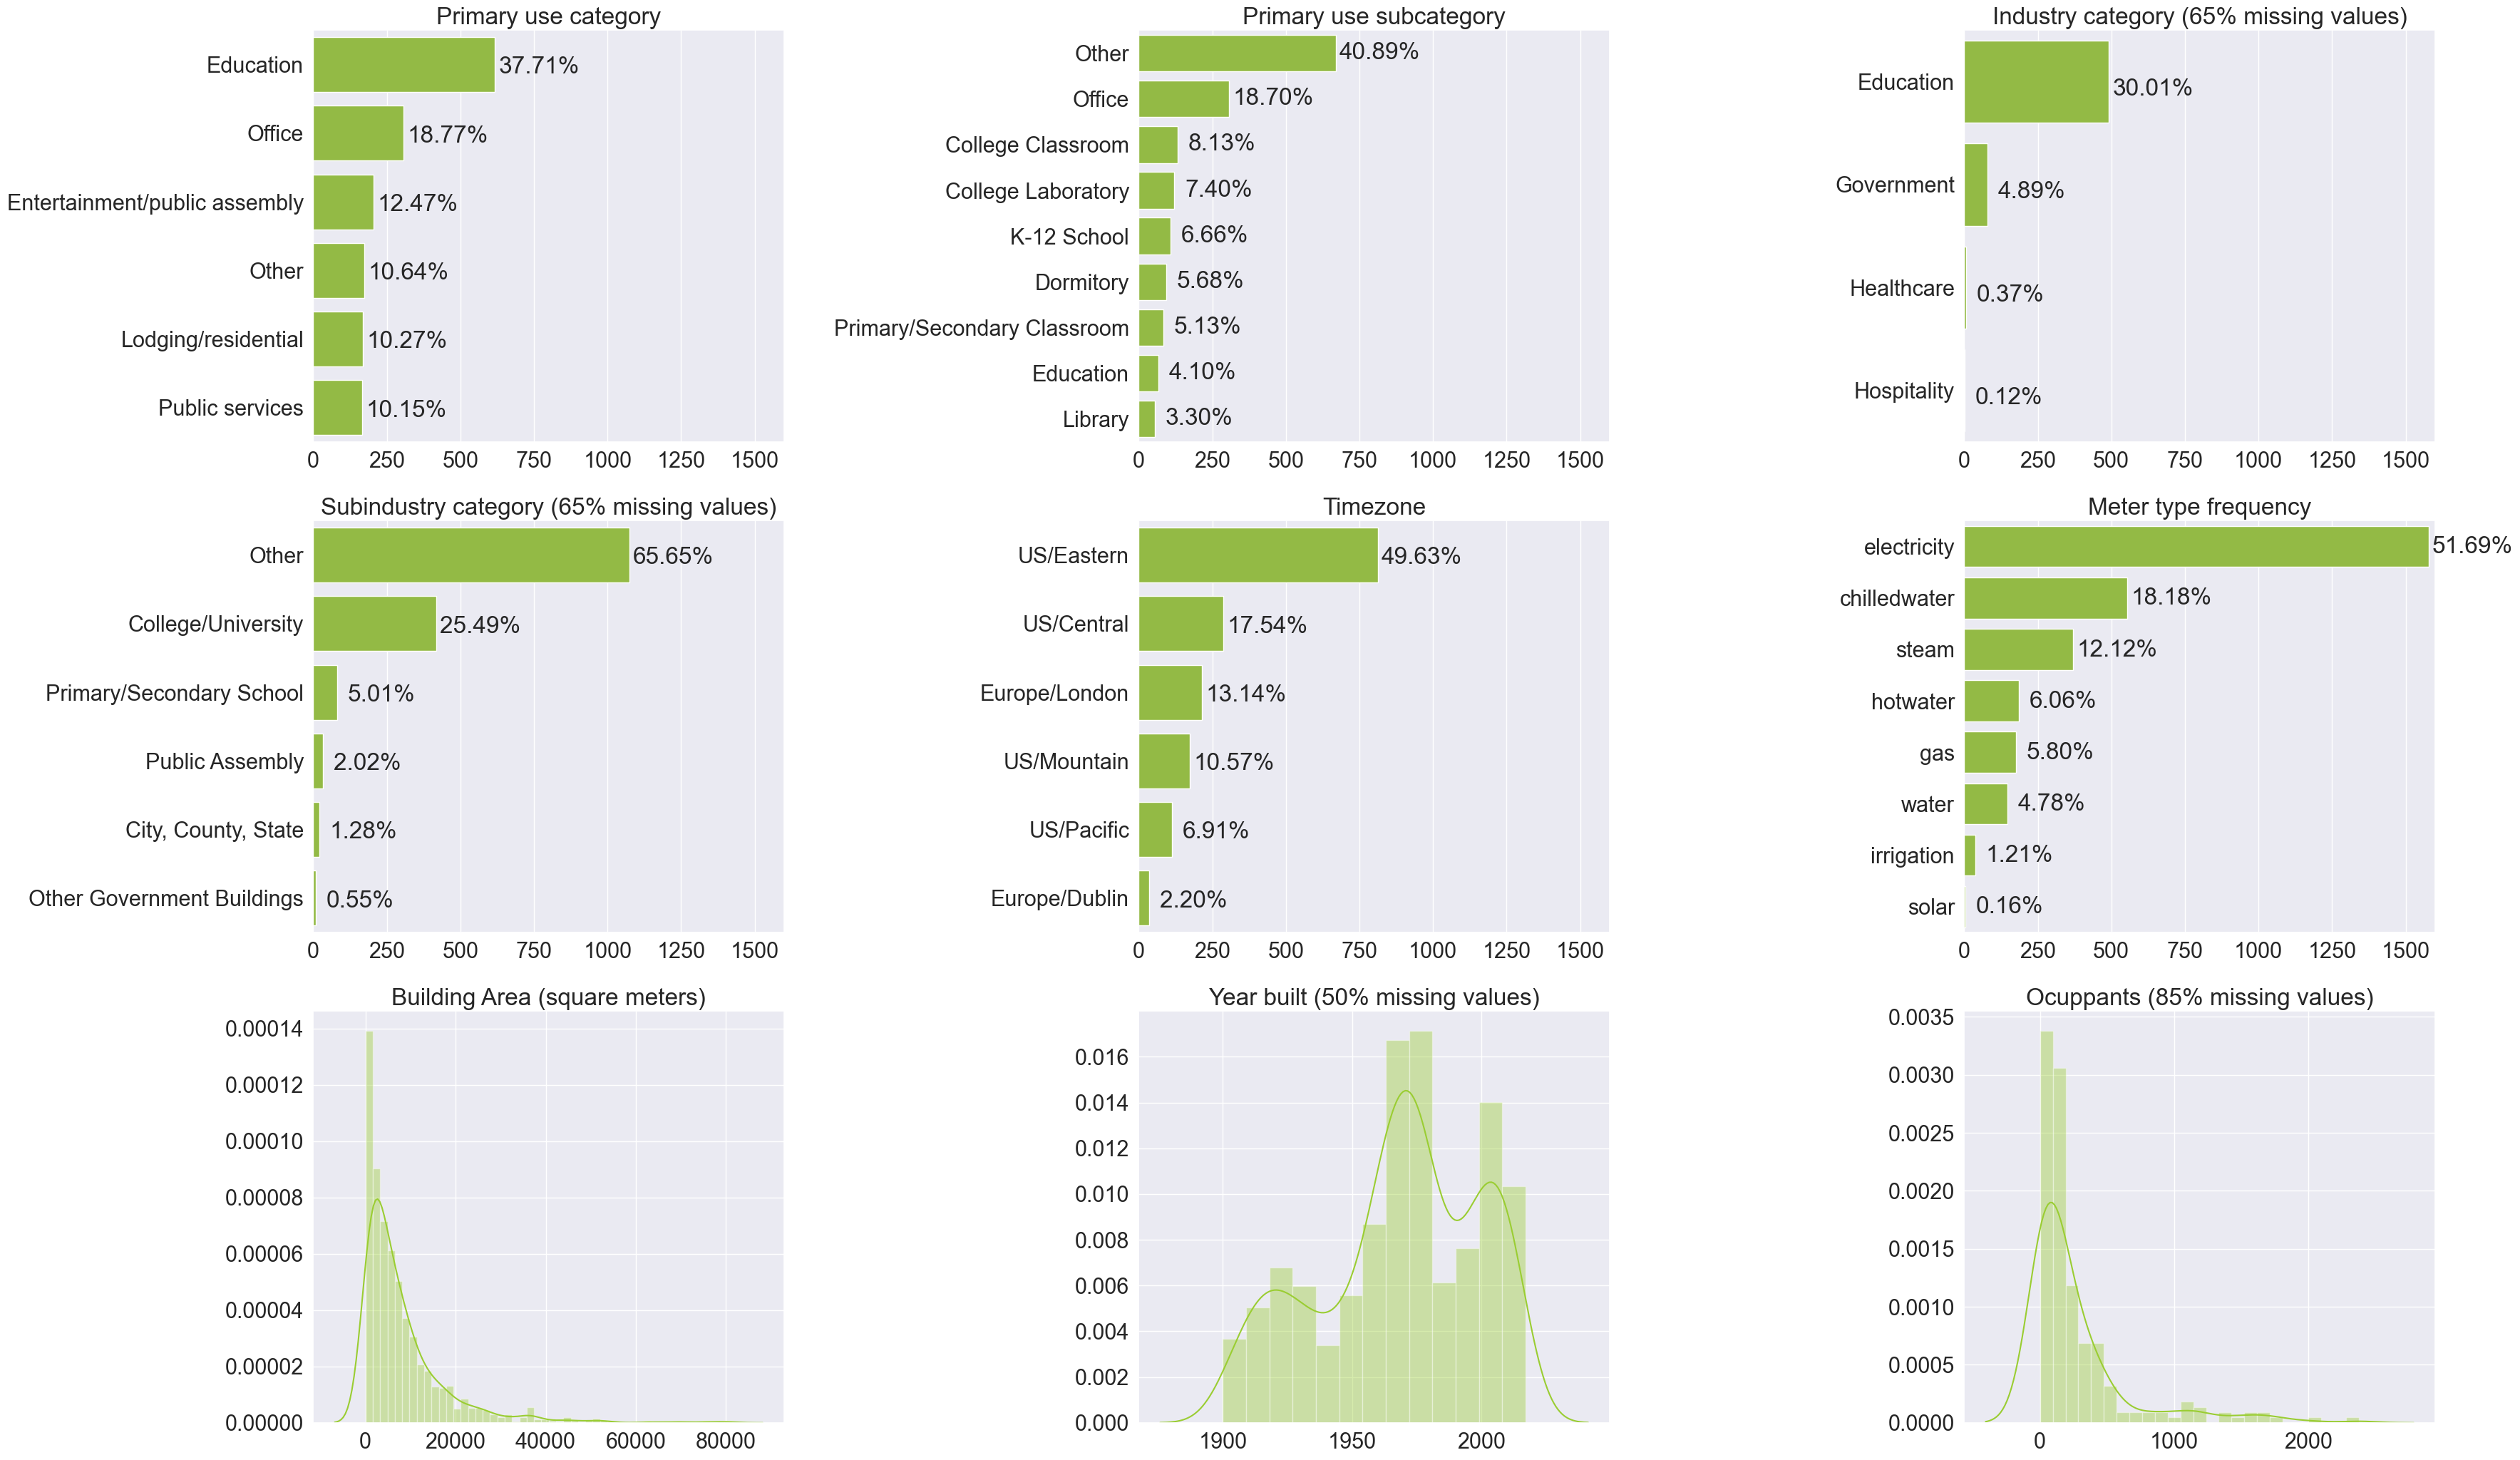

In [29]:
sns.set(rc={'figure.figsize':(36,21)})
sns.set(font_scale = 2)
f, axes = plt.subplots(3, 3)

axes = axes.flatten()

color = "yellowgreen"

# primary use category countplot in decreasing order
# Temporary dataset
top5 = list(metadata['primaryspaceusage'].value_counts().iloc[:5].index)
temp = metadata[["primaryspaceusage"]].copy()
temp.loc[temp.primaryspaceusage.isin(top5) == False, "primaryspaceusage"] = "Other"
# Plot
ax1 = axes[0]
g1 = sns.countplot(data=temp, y="primaryspaceusage", color= color, orient="h", ax=ax1, order = temp['primaryspaceusage'].value_counts().index)
ax1.title.set_text('Primary use category')
ax1.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(metadata)) # number of buildings
for p in g1.patches:
    width = p.get_width()
    g1.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)
    
# primary use subcategory countplot in decreasing order
# Temporary dataset
top5 = list(metadata['sub_primaryspaceusage'].value_counts().iloc[:8].index)
temp = metadata[["sub_primaryspaceusage"]].copy()
temp.loc[temp.sub_primaryspaceusage.isin(top5) == False, "sub_primaryspaceusage"] = "Other"
# Plot
ax2 = axes[1]
g2 = sns.countplot(data=temp, y="sub_primaryspaceusage", color= color, orient="h", ax=ax2, order = temp['sub_primaryspaceusage'].value_counts().iloc[:16].index)
ax2.title.set_text('Primary use subcategory')
ax2.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(metadata)) # number of buildings
for p in g2.patches:
    width = p.get_width()
    g2.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)

# industry countplot in decreasing order
ax3 = axes[2]
g3 = sns.countplot(data=metadata, y="industry", color=color, ax=ax3, orient="h", order = metadata['industry'].value_counts().index)
ax3.title.set_text('Industry category (65% missing values)')
ax3.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(metadata)) # number of buildings
for p in g3.patches:
    width = p.get_width()
    g3.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# subindustry countplot in decreasing order
# Temporary dataset
top5 = list(metadata['subindustry'].value_counts().iloc[:5].index)
temp = metadata[["subindustry"]].copy()
temp.loc[temp.subindustry.isin(top5) == False, "subindustry"] = "Other"
# Plot
ax4 = axes[3]
g4 = sns.countplot(data=temp, y="subindustry", color=color, ax=ax4, orient="h", order = temp['subindustry'].value_counts().index)
ax4.title.set_text('Subindustry category (65% missing values)')
ax4.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(metadata)) # number of buildings
for p in g4.patches:
    width = p.get_width()
    g4.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)

# timezone countplot in decreasing order
ax5 = axes[4]
g5 = sns.countplot(data=metadata, y="timezone", color=color, ax=ax5, orient="h", order = metadata['timezone'].value_counts().index)
ax5.title.set_text('Timezone')
ax5.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = float(len(metadata)) # number of buildings
for p in g5.patches:
    width = p.get_width()
    g5.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# Meters type frequency
ax6 = axes[5]
# Temporal datafram
temp = pd.melt(metadata[["building_id","electricity","hotwater","chilledwater","steam","water","irrigation","gas","solar"]],id_vars = "building_id", var_name="meter")
# plot
g6 = sns.countplot(data=temp.loc[temp['value']=="Yes"], y='meter', color= color, ax=ax6, orient="h", order = temp.loc[temp['value']=="Yes"]["meter"].value_counts().index)
g6.title.set_text('Meter type frequency')
g6.set(ylabel="", xlabel="", xlim=(0,1600))
# adds percentage    
total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0] # number of meters
for p in g6.patches:
    width = p.get_width()
    g6.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center")    
del(temp)
    
# "sqft" histogram
ax7 = axes[6]
g7 = sns.distplot(metadata["sqm"], ax=ax7, color=color)
g7.set(ylabel="", xlabel="")
ax7.set_title('Building Area (square meters)')

# "yearbuilt" histogram
ax8 = axes[7]
g8 = sns.distplot(metadata["yearbuilt"].dropna(), ax=ax8, color=color)
g8.set(ylabel="", xlabel="")
ax8.set_title('Year built (50% missing values)')

# "occupants" histogram
ax9 = axes[8]
g9 = sns.distplot(metadata["occupants"].dropna(), ax=ax9, color=color)
g9.set(ylabel="", xlabel="")
ax9.set_title('Ocuppants (85% missing values)')
   
plt.tight_layout()